## MT parameter calculation
The mt module contains classes for estimating MTR and MTSat parameters. These are subclasses of Fitter, which means they can be used to fit a single MT value (using the proc method) or all voxels within a set of MT images (using the proc_image method).

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../src')
import mt
from utils.imaging import read_images, write_image
%load_ext autoreload
%autoreload 2

## MT calculations
Estimate MTR from the MT on and off values

In [2]:
s_on, s_off = 19, 20  # MTR is 5%, i.e. 20% reduction in signal
s = np.array((s_on, s_off))  # input signal is array of ON, OFF signals
mtr_fitter = mt.MTR()  # create MTR fitting object
mtr_fitter.proc(s)  # use proc method to calculate MTR value

5.0

### Generate MTR map from multi-echo GRE data

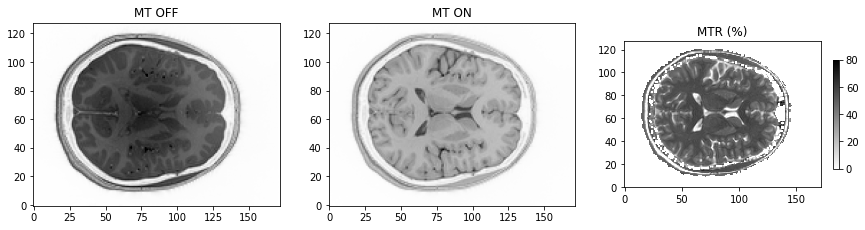

In [3]:
# Load images, combine echoes and calculate MTR map
echoes = 1, 2, 3
nii_dir = r'V:\temp\mtsat_test'  # folder containing nii files
# load MT ON images into 4D array containing all echoes, then sum over all required echoes (i.e. over last dimension of array)
mt_on, hdr = read_images([f'{nii_dir}\\mtsaton_e{n}.nii' for n in echoes])
mt_on = np.sum(mt_on, axis=-1)
write_image(mt_on, f'{nii_dir}\\mt_on_sum', hdr)
# repeat for MT OFF images
mt_off, hdr = read_images([f'{nii_dir}\\mtsatoff_e{n}.nii' for n in echoes])
mt_off = np.sum(mt_off, axis=-1)
write_image(mt_off, f'{nii_dir}\\mt_off_sum', hdr)

# stack the (echo-summed) ON and OFF images into single array
s = np.stack((mt_on, mt_off), axis=-1)
# generate MTR map using proc_image method of MTR fitting object
mtr_map = mtr_fitter.proc_image(s, threshold=100, dir=nii_dir, template=f'{nii_dir}\\mtsatoff_e1.nii')

# plot slice through images
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(mt_off[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=2000)
ax[0].set_title('MT OFF')
ax[1].imshow(mt_on[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=2000)
ax[1].set_title('MT ON')
cax = ax[2].imshow(mtr_map[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=80)
ax[2].set_title('MTR (%)')
fig.colorbar(cax, shrink=0.2);

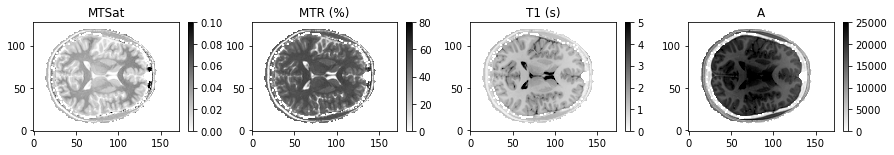

In [4]:
# load and sum T1w images
t1w, hdr = read_images([f'{nii_dir}\\mtsatt1w_e{n}.nii' for n in echoes])
t1w = np.sum(t1w, axis=-1)
write_image(t1w, f'{nii_dir}\\t1w_sum', hdr)

# stack the (echo-summed) ON, OFF and T1w images into single array
s = np.stack((mt_on, mt_off, t1w), axis=-1)
# generate MTR map using proc_image method of MTR fitting object
mtsat_fitter = mt.MTSat(fa_mt=5, fa_pd=5, fa_t1=18, tr_pd=30e-3, tr_t1=15e-3)  # create MTSat fitting object
mtsat_map, mtr_map, t1_map, r1_map, a_map = mtsat_fitter.proc_image(s, threshold=100, dir=nii_dir, template=f'{nii_dir}\\mtsatoff_e1.nii')

# plot slice through images
fig, ax = plt.subplots(1,4, figsize=(15,10))
im0 = ax[0].imshow(mtsat_map[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=0.1)
ax[0].set_title('MTSat')
fig.colorbar(im0, ax=ax[0], shrink=0.2)
im1 = ax[1].imshow(mtr_map[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=80)
ax[1].set_title('MTR (%)')
fig.colorbar(im1, ax=ax[1], shrink=0.2)
im2 = ax[2].imshow(t1_map[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=5)
ax[2].set_title('T1 (s)')
fig.colorbar(im2, ax=ax[2], shrink=0.2)
im3 = ax[3].imshow(a_map[:,:,90], cmap="gray_r", origin="lower", vmin=0, vmax=25000)
ax[3].set_title('A')
fig.colorbar(im3, ax=ax[3], shrink=0.2);